### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

***
# BCI-IL WS 2018/2019 - Exercise Sheet #01
***

#### Name:

This exercise sheet refers to lecture \#2. The dataset is taken from an ERP Speller experiment, similar to the one discussed in the lecture. The first two tasks are about basic visualizations of Event-Related Potentials (ERPs), and the third one is the implementation of a univariate measure of separability and its visualization.

In [2]:
% matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Loading Data

In [3]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Plotting ERPs  (5 points)

Plot the average ERPs corresponding to *target* and *nontarget* stimuli in the time interval -100 to 1000 ms for the channels Cz and PO7. This means that the average ERPs are class and channel-wise. <br>
In order to make the curves look reasonable, a so called 'baseline correction' should be performed: for each channel and trial, calculate the average across the prestimulus time interval -100 to 0 ms. This results in one value per channel and trial. Subtract this 'baseline' value from each (single channel/single trial) time course. 
The function `baseline` is provided in the `bci_minitoolbox`.
<font color=red>**It is recommended**</font> to have a look at the code of `bci.baseline`! It is three lines only, and shows, e.g., how to get the indices within an epoch that correspond to a given time interval. This will prove useful in future exercises.

(111, 55)


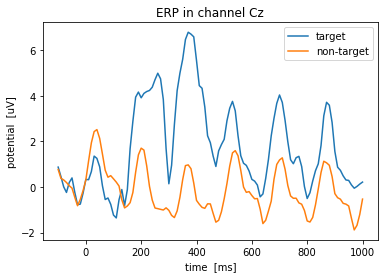

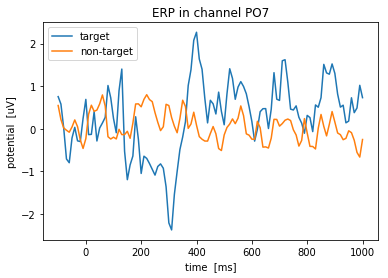

In [4]:
# Store given information in variables. Subsequent code should only refer to these variables and not
# contain the constants.
ival= [-100, 1000]
ref_ival= [-100, 0]
chans = ['Cz', 'PO7']

# Segment continuous data into epochs:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
# Baseline correction:
epo = bci.baseline(epo, epo_t, ref_ival)
# get the mean for all epochs/trials for the given channel
# result is: 111 samples x 55 channel
mean_target = np.mean(epo[:,:,mrk_class == 0], axis = 2) # for mean over epoch 
mean_non_target = np.mean(epo[:, :, mrk_class == 1], axis = 2) 

for channel_name in chans:
    channel_index = clab.index(channel_name)
    average_erps_of_channel_for_target = mean_target[:,channel_index]
    average_erps_of_channel_for_non_target = mean_non_target[:,channel_index]
    
    plt.figure()
    plt.plot(epo_t, average_erps_of_channel_for_target, label = mrk_className[0])
    plt.plot(epo_t, average_erps_of_channel_for_non_target, label = mrk_className[1])
    plt.title('ERP in channel {}'.format(channel_name))
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()

## Exercise 2: Scalp Topographies of ERPs  (5 points)

Calculate the average potential separately for the classes *target* and *non-target* in the following time intervals [ms]: [160 200], [230 260], [300 320], and [380 430]. (This involves averaging over all trials of the respective class and averaging over all sample points in the respective time interval.)
Visualize the result as scalp topographies using the function `bci.scalpmap`, i.e., 4 maps for each class. <br>
**Note:** In order to make the maps look reasonable, do a *baseline correction* as in the previous task. To make the maps comparable, use a common scale for the colorbar (see help of `scalpmap`).

(array([26, 27, 28, 29, 30]),)
(array([33, 34, 35, 36]),)
(array([40, 41, 42]),)
(array([48, 49, 50, 51, 52, 53]),)


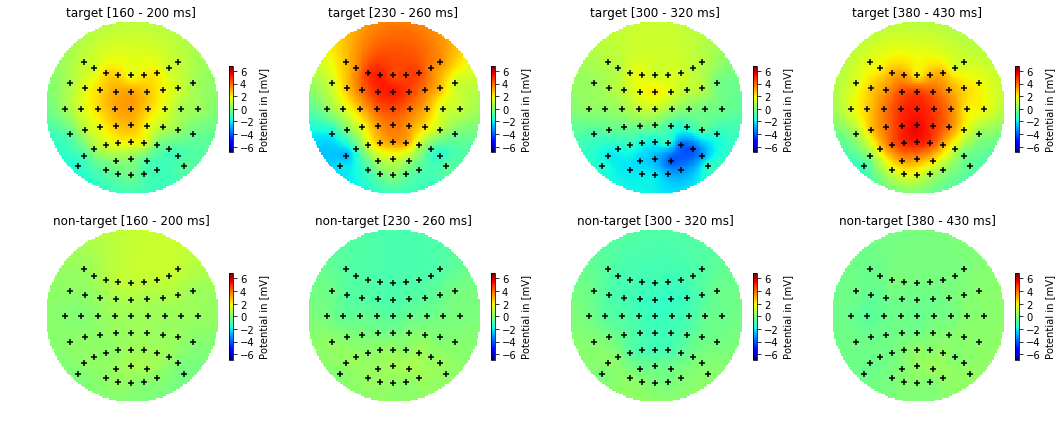

In [6]:
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]
# epochs already calcultated

# mean_target and non was given from exercise 1
max_amplitude = np.vstack((abs(mean_target), abs(mean_non_target))).max()
# average potential separate
## for target and non target
## average over all class and all sample points in time interval
plt.figure(figsize=(18, 7))
for interval_index in range(len(ival)):
    # get indices of markers (91) in interval
    start_interval = ival[interval_index][0] # e.g. 160
    end_interval = ival[interval_index][1] # e.g. 200
    # get sample indices just for time interval, [0] because you get back tupel of e.g.([40, 41, 42], nothing)
    indices_range_of_interval = np.where((start_interval <= epo_t) & (epo_t <= end_interval))[0]
    # get mean in samples inteval (see ival) of all channels and all samples (55, 1200)
    # calculate the mean in the sample range for each channel over all epochs in the time interval
    mean_sensor_values_for_both_classes = np.mean(epo[indices_range_of_interval, :, :], axis = 0)
    
    for classifier in range(2): # 0 and 1 
        amount_of_intervals = len(ival)
        # plot the scalmap
        # 2 rows, 4 columns, position[1..8]
        plt.subplot(2, 4, 1 + classifier*amount_of_intervals + interval_index)
        # Get mean for each channel over all epochs/trials(according to target or nontarget)
        mean_sensor_values_for_class = np.mean(mean_sensor_values_for_both_classes[:, mrk_class == classifier], axis = 1)
        # mnt = electrode montage x,y of sensors
        bci.scalpmap(mnt, mean_sensor_values_for_class, clim=(-max_amplitude,max_amplitude), cb_label='Potential in [mV]') 
        plt.title('{} [{} - {} ms]'.format(mrk_className[classifier], ival[interval_index][0], ival[interval_index][1]))

## Exercise 3: Visualization with the Biserial Correlation Coefficient  (5 points)

Implement a function for the calculation of the signed `r^2`-value (see point-biserial correlation coefficient in BCI lecture \#02). From the given data set, extract epochs for the time interval [-100 600] ms relativ to each stimulus presentation.  Calculate for each channel and each point in time the signed `r^2`-value wrt. classes
*target* vs. *non-target* and visualize this (channel `x` time points) matrix (`pl.imshow`). Again, use 100 ms prestimulus for baseline correction.

In [7]:
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    # separate epochs in target and non-target
    epo_target = epo[:, :, y==0]
    epo_non_target = epo[:, :, y==1]
    
    N1 = epo_target.shape[2] # amount of target epochs/trials
    N2 = epo_non_target.shape[2] # amount of non-target epochs/trials
    
    # mean normalization
    const = np.float(N1*N2) / ((N1+N2)**2) 
    mean_difference = epo_target.mean(axis=2) - epo_non_target.mean(axis=2)
    variance = epo.var(axis=2)
    return np.sign(mean_difference) * const * (mean_difference)**2 / variance

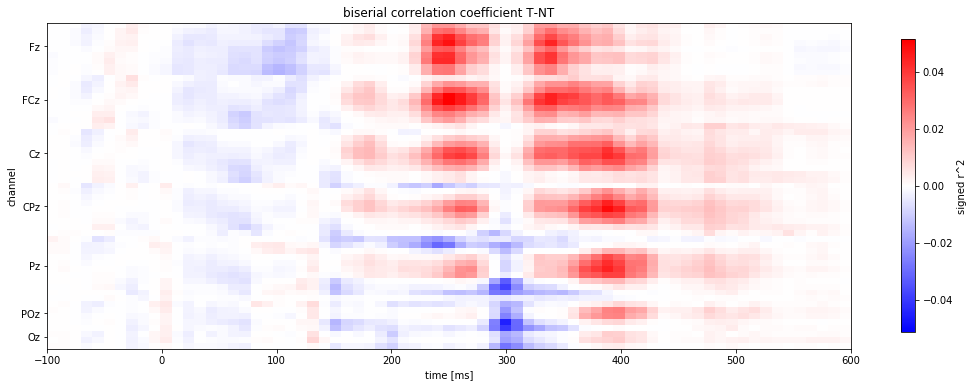

In [9]:
ival = [-100, 600]
reference_interval = [-100, 0]

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
epo = bci.baseline(epo, epo_t, reference_interval)

# do the biserial correlation
epo_r_square = signed_r_square(epo, mrk_class)

# get max value of pb-coefficient epochs
plt.figure(figsize=(18,6))
# time(x): -100 till 600 , channel(y): 0 till 55 
bounding_box_of_axis = (epo_t[0], epo_t[-1], epo.shape[1], 0)

plt.imshow(epo_r_square.T, extent=bounding_box_of_axis, aspect='auto', 
           vmin=-epo_r_square.max(), vmax=epo_r_square.max(), interpolation='None', cmap='bwr')
plt.colorbar(shrink=0.9, label='signed r^2')
plt.title('biserial correlation coefficient T-NT')
plt.xlabel('time [ms]')
plt.ylabel('channel')
selected_channels = ['Fz','FCz','Cz','CPz','Pz','POz','Oz']
idx_z = [clab.index(x) for x in selected_channels]
plt.yticks(idx_z, selected_channels);